# Мэтчинг товаров маркетплейса

Цель проекта - для каждого объекта из `validation.csv` найти один или несколько объектов из всего списка товаров `base.csv`, которые близки к нему по некоторой заданной метрике

Задачи: 
- разработать алгоритм, который для всех товаров из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base.csv`;
- оценить качество алгоритма по метрике `accuracy@5`.

Описание данных:
- `base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный `id` (`0-base`, `1-base`, `2-base`) и вектор признаков размерностью 72.

- `train.csv` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный `id` (`0-query`, `1-query`, …) , вектор признаков И `id` товара из `base.csv`, который максимально похож на него (по мнению экспертов).

- `validation.csv` - датасет с товарами (уникальный `id` и вектор признаков), для которых надо найти наиболее близкие товары из `base.csv`

- `validation_answer.csv` - правильные ответы к предыдущему файлу.


## Импорты библиотек и загрузка данных

In [1]:
!pip install faiss

In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import faiss

from tqdm.notebook import tqdm

In [3]:
df_base = pd.read_csv('base.csv', index_col=0)
df_train = pd.read_csv('train.csv', index_col=0)
df_valid = pd.read_csv('validation.csv', index_col=0)
df_valid_ans = pd.read_csv('validation_answer.csv', index_col=0)

### `df_base`

In [4]:
df_base.shape

(2918139, 72)

In [5]:
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


### `df_train`

In [6]:
df_train.shape

(100000, 73)

In [7]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [8]:
target_train = df_train['Target']
df_train.drop('Target', axis=1, inplace=True)

### `df_valid`

In [9]:
df_valid.shape

(100000, 72)

In [10]:
df_valid.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


### `df_valid_ans`

In [11]:
df_valid_ans.shape

(100000, 1)

In [12]:
df_valid_ans.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


## Предобработка и исследовательский анализ данных

### Пропуски

In [13]:
print('Количество пропусков:', sum(df_base.isna().sum().values.tolist()))

Количество пропусков: 0


### Дубликаты

In [14]:
print('Количество дубликатов:', df_base.duplicated().sum())

Количество дубликатов: 0


### Распределение

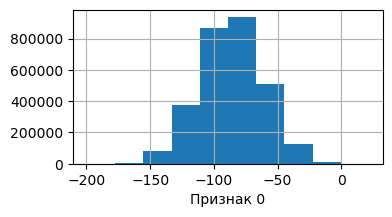

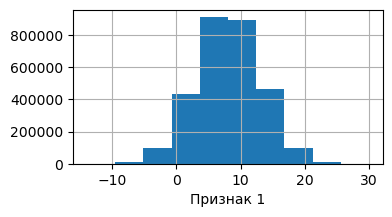

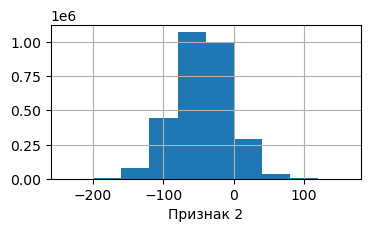

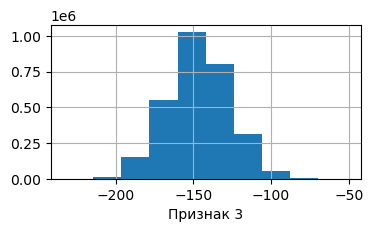

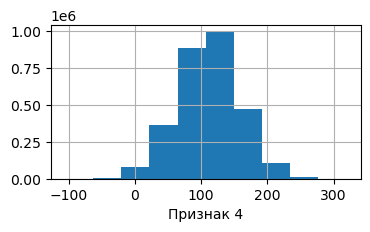

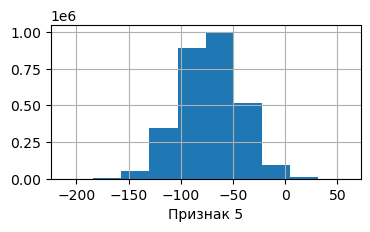

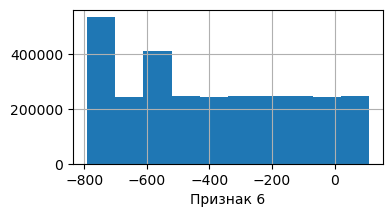

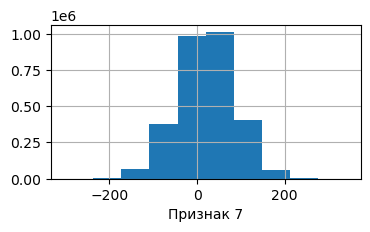

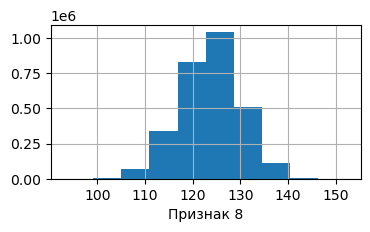

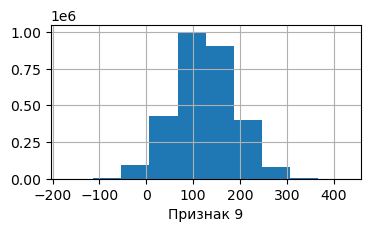

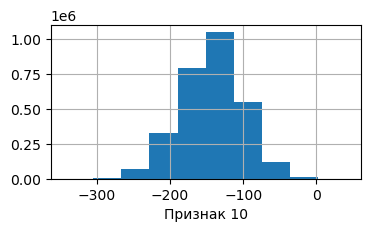

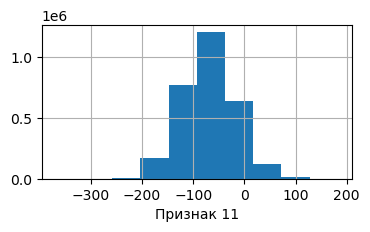

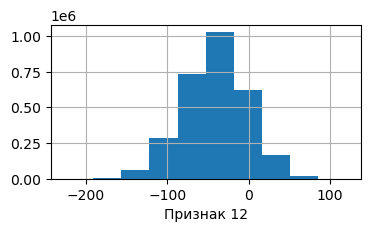

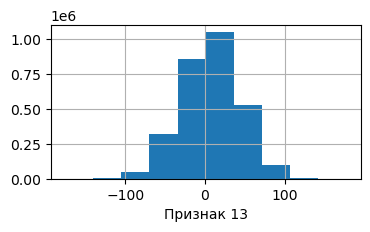

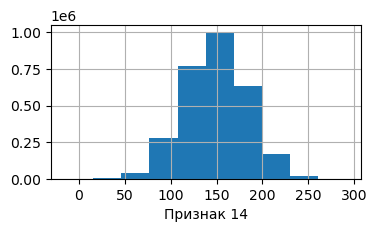

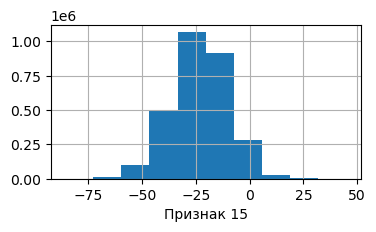

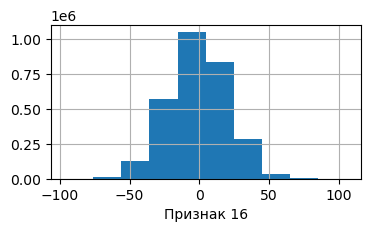

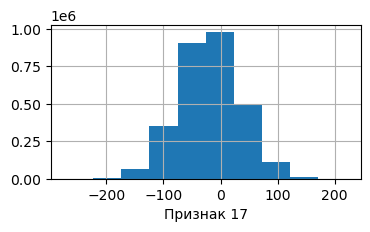

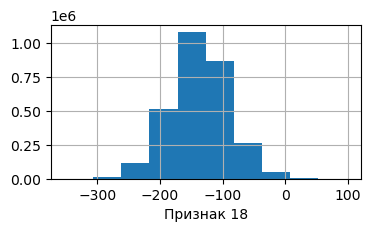

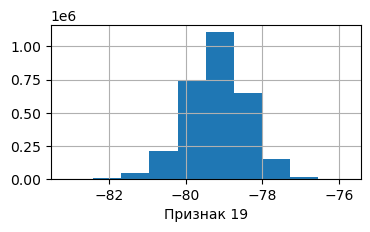

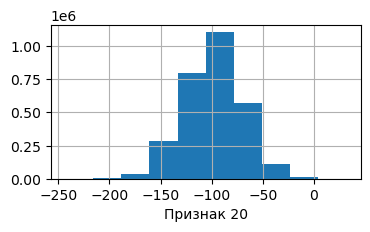

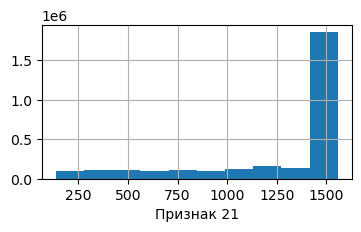

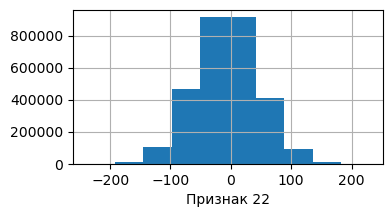

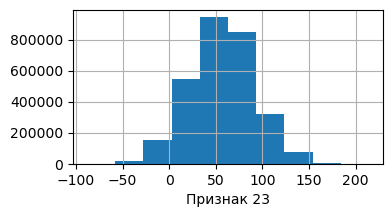

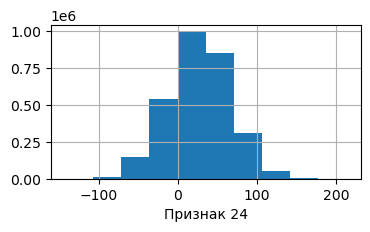

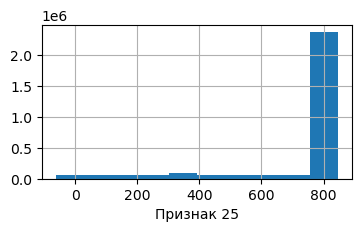

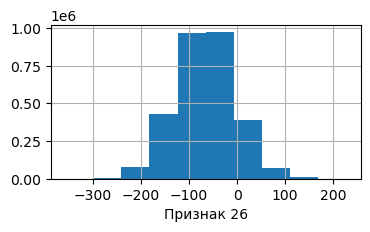

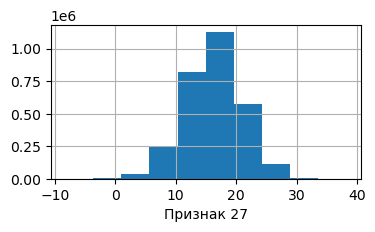

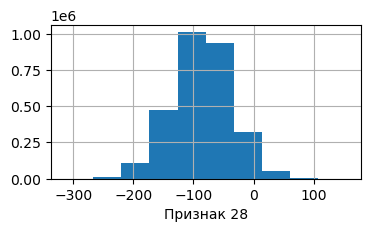

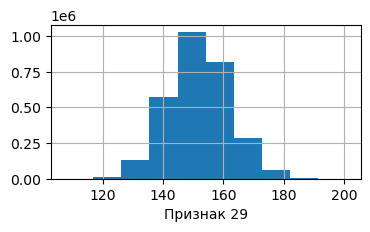

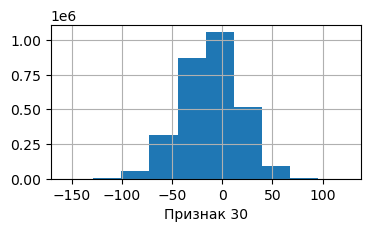

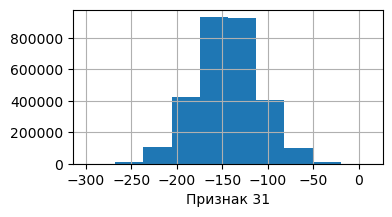

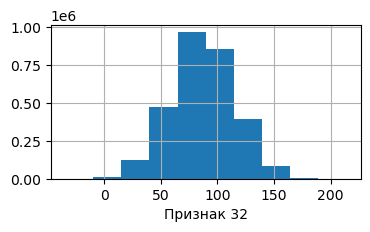

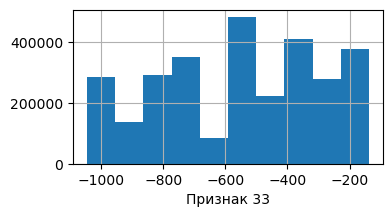

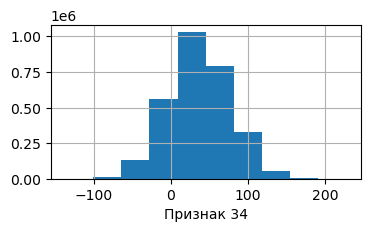

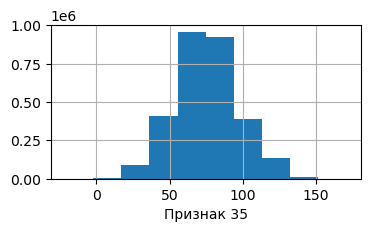

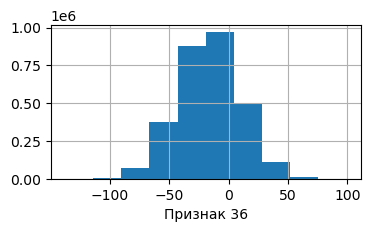

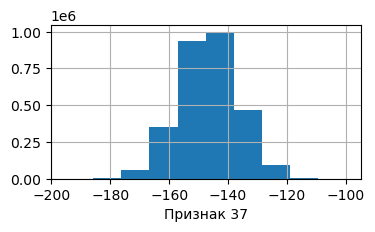

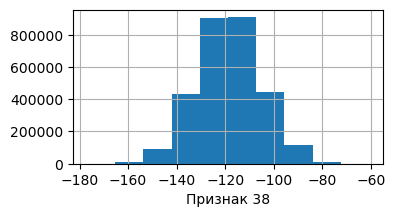

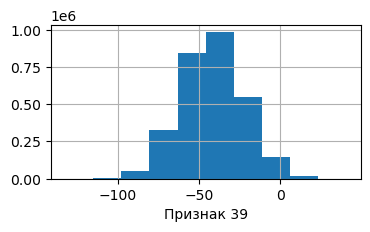

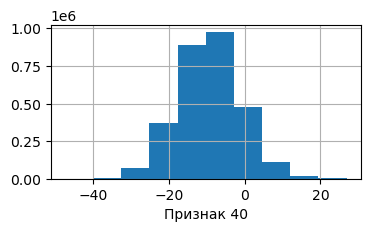

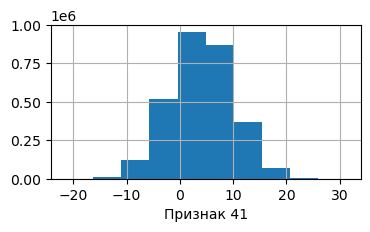

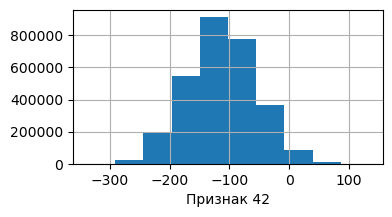

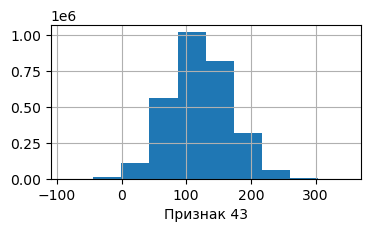

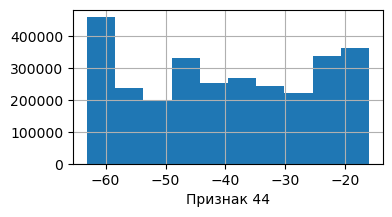

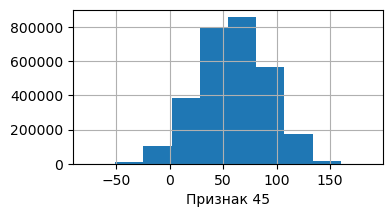

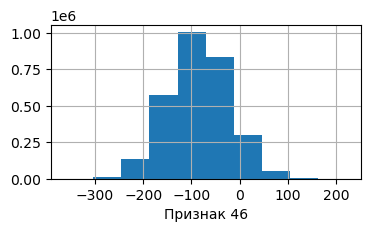

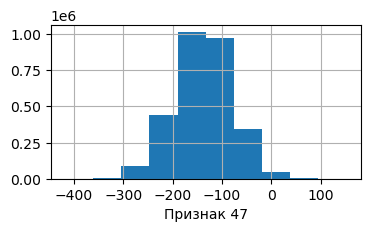

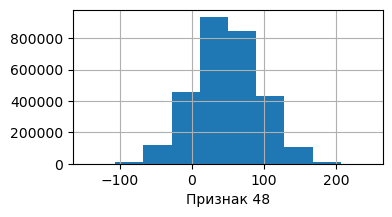

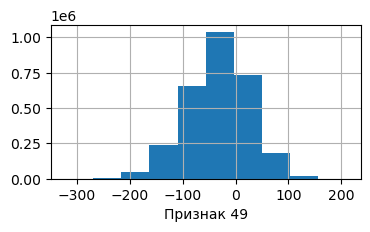

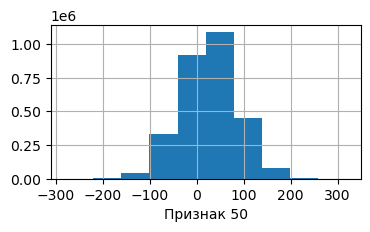

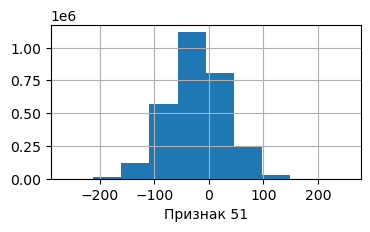

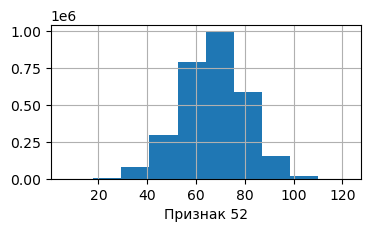

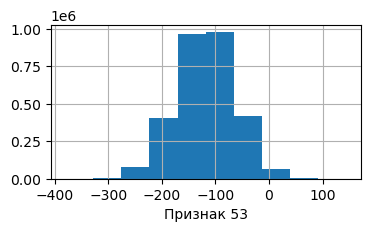

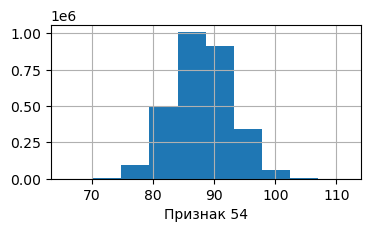

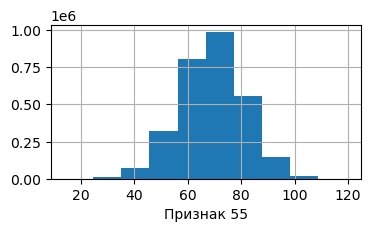

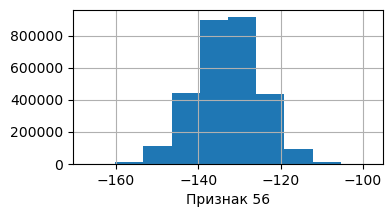

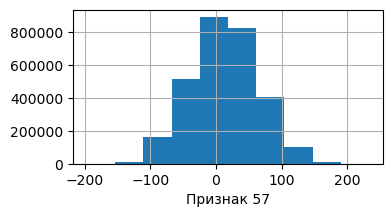

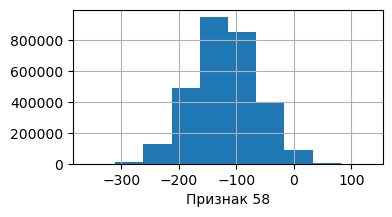

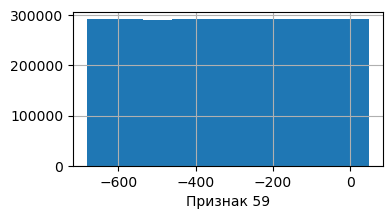

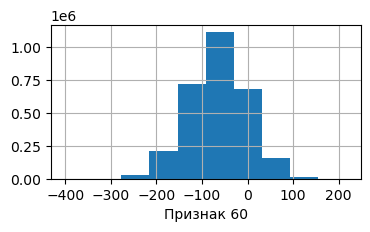

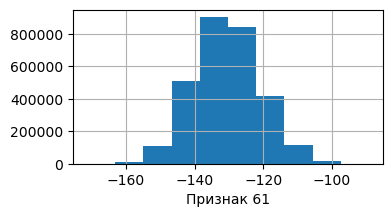

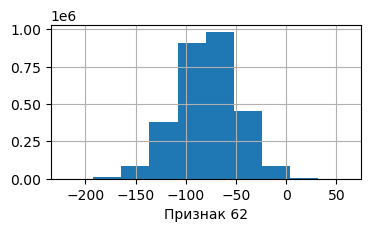

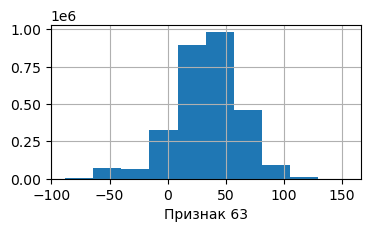

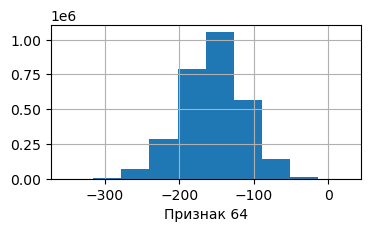

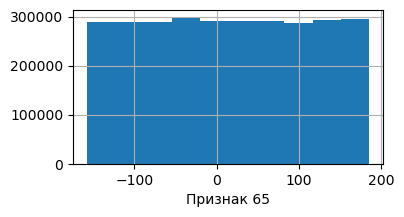

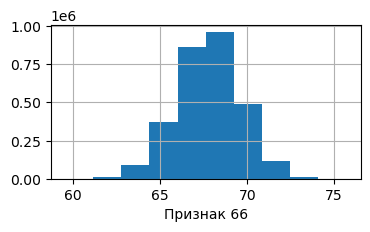

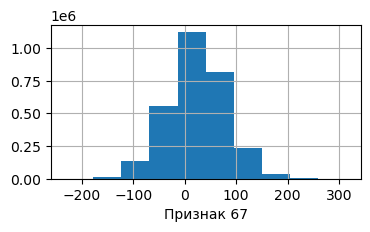

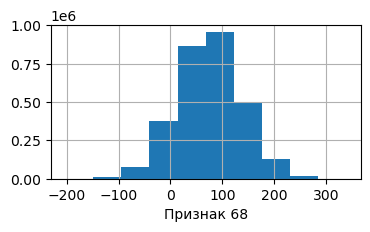

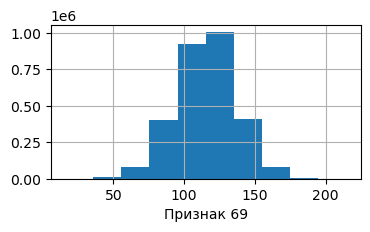

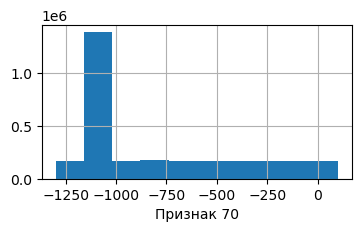

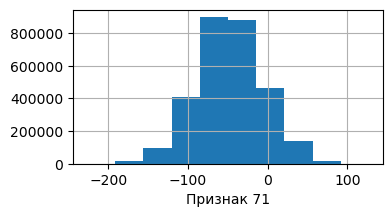

In [15]:
for i in range(df_base.shape[1]):
    plt.figure(figsize=(4,2))
    plt.grid(True)
    
    plt.hist(df_base[str(i)])
    
    x_label = 'Признак ' + str(i)
    plt.xlabel(x_label)
    
    plt.show()

Большинство признаков визуально имеют распределение близкое к нормальному, за исключением столбцов под номерами `6`, `21`, `25`, `33`, `44`, `59`, `65` и `70`.

In [16]:
feature_norm_columns = [
    '0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', 
    '24', '26', '27', '28', '29', '30', '31', '32', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '45', '46', '47', 
    '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '60', '61', '62', '63', '64', '66', '67', '68', '69', '71'
]

In [17]:
feature_all_columns = df_base.columns.to_list()

### Стандартизация

In [18]:
standard_scaler = StandardScaler()

df_base_ss = pd.DataFrame(standard_scaler.fit_transform(df_base[feature_all_columns]), index=df_base.index, columns=df_base.columns)
df_train_ss = pd.DataFrame(standard_scaler.transform(df_train[feature_all_columns]), index=df_train.index, columns=df_train.columns)
df_valid_ss = pd.DataFrame(standard_scaler.transform(df_valid[feature_all_columns]), index=df_valid.index, columns=df_valid.columns)

## Подготовка к мэтчингу с использованием `FAISS`

In [19]:
def create_idx_l2(data):
    dims = data.shape[1]
    n_cells = 1
    
    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
    
    idx_l2.train(np.ascontiguousarray(data.values[:50000, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(data.values).astype('float32'))
    
    data_index = {k: v for k, v in enumerate(data.index.to_list())}
    
    return idx_l2, data_index

In [20]:
def get_accuracy5(data_base, features, target):
    idx_l2, data_index = create_idx_l2(data_base)
    
    r, idx = idx_l2.search(np.ascontiguousarray(features.values).astype('float32'), 5)
    
    acc = 0
    for t, el in zip(target.values.tolist(), idx.tolist()):
        acc += int(t in [data_index[r] for r in el])
    
    accuracy5 = 100 * acc / len(idx)
    return accuracy5

## Настройка  на `train`

Протестируем разные данные:
1. данные со всеми колонками;
2. данные с колонками, имеющими распределение близкое к нормальному;
3. стандартизированные данные со всеми колонками;
4. стандартизированные данные с колонками, имеющими распределение близкое к нормальному.

In [21]:
accuracy5_1 = get_accuracy5(df_base[feature_all_columns], df_train[feature_all_columns], target_train)
print('accuracy5_1 готов')
accuracy5_2 = get_accuracy5(df_base[feature_norm_columns], df_train[feature_norm_columns], target_train)
print('accuracy5_2 готов')
accuracy5_3 = get_accuracy5(df_base_ss[feature_all_columns], df_train_ss[feature_all_columns], target_train)
print('accuracy5_3 готов')
accuracy5_4 = get_accuracy5(df_base_ss[feature_norm_columns], df_train_ss[feature_norm_columns], target_train)
print('accuracy5_4 готов')

accuracy5_1 готов
accuracy5_2 готов
accuracy5_3 готов
accuracy5_4 готов


In [25]:
dict_accuracy = {
    'Ситуация 1': accuracy5_1,
    'Ситуация 2': accuracy5_2,
    'Ситуация 3': accuracy5_3,
    'Ситуация 4': accuracy5_4
}

df_accuracy = pd.DataFrame(list(dict_accuracy.items()), columns=['Данные', 'accuracy5'])
df_accuracy

,Данные,accuracy5
0,Ситуация 1,13.804
1,Ситуация 2,69.682
2,Ситуация 3,65.838
3,Ситуация 4,71.082


**Вывод:** наибольшее значение метрики 71.082 получилось с использованием стандартизированных данных с колонками, имеющими распределение близкое к нормальному. Будем использовать их для расчета `accuracy5` на валидационной выборке.

## Проверка на `validation`

In [26]:
accuracy5_valid = get_accuracy5(df_base_ss[feature_norm_columns], df_valid_ss[feature_norm_columns], df_valid_ans['Expected'])

In [27]:
print('Метрика accuracy5 на валидационной выборке составила:', accuracy5_valid)

Метрика accuracy5 на валидационной выборке составила: 70.984


## Общий вывод

**1. Обзор и обработка данных**

Для анализа и сопоставления товаров было получено 4 файла данных:
- `base.csv` - общий датасет со всеми товарами (2_918_139 товаров);
- `train.csv` - датасет для обучения, содержит колонку `target`, размеченную экспертами (100_000 товаров);
- `validation.csv` - валидационная выборка (100_000 товаров);
- `validation_answer.csv` - ответы для валидационной выборки.

`base.csv`, `train.csv` и `validation.csv` содержат 72 колонки с признаками товаров.

Так же необходимо отметить, что товары из обучающей и валидационной выборок входят в состав датасета со всеми товарами.

Во время обработки данных не были обнаружены пропуски и дубликаты.

Обзор на распределения признаков показал, что большинство имеет распределение близкое к нормальному, за исключением колонок `6`, `21`, `25`, `33`, `44`, `59`, `65` и `70`.

Так же на этом этапе отдельно были сформированы датафреймы со стандартизированными данными для каждой выборки.

**2. Мэтчинг товаров**

Для решения задачи сопоставления выбрана библиотека `FAISS`, в качестве оценки схожести элементов - расчет евклидового расстояния. Для оценки качества модели использована метрика `accuracy@5`, которая показывает долю правильно подобранных товаров.

Рассматривалось несколько случаев расчета метрики с использованием разных данных:
- данные со всеми колонками;
- данные с колонками, имеющими распределение близкое к нормальному;
- стандартизированные данные со всеми колонками;
- стандартизированные данные с колонками, имеющими распределение близкое к нормальному.

Самое большое значение метрики показали стандартизированные данные с колонками, имеющими распределение близкое к нормальному - 71.082.

На их основе рассчитано значение `accuracy@5` на валидационной выборке, оно составило 70.984. 